## 1. Importing datsets

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
full_dataset2 = pd.read_csv('datasets\\full_dataset_2.csv')
full_dataset3 = pd.read_csv('datasets\\full_dataset_3.csv')

## 2. Balancing data

In [3]:
def plot_count(count):
    plt.rcdefaults()
    fig, ax = plt.subplots()

    count0 = counter[0]
    count1 = counter[1]
    total = count0 + count1
    amount = (count0/total, count1/total)

    ax.barh([0,1], amount, align='center')
    ax.set_yticks([0,1])
    ax.set_yticklabels([0,1])
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('% of data')
    ax.set_ylabel('Hate detection')
    ax.set_title('Data distribution')
    
    a = round(amount[0], 2)*100
    ax.text(0.75, 0, str(a) + '%', color='black')
    b = round(amount[1], 2)*100
    ax.text(0.26, 1, str(b) + '%', color='black')

    plt.xlim([0.0, 1.0])
    plt.show()

In [4]:
from collections import Counter
counter = Counter(full_dataset2['hate_speech'])
print('Class 0: {}, Class 1: {}'.format(counter[0],counter[1]))

Class 0: 5271, Class 1: 1647


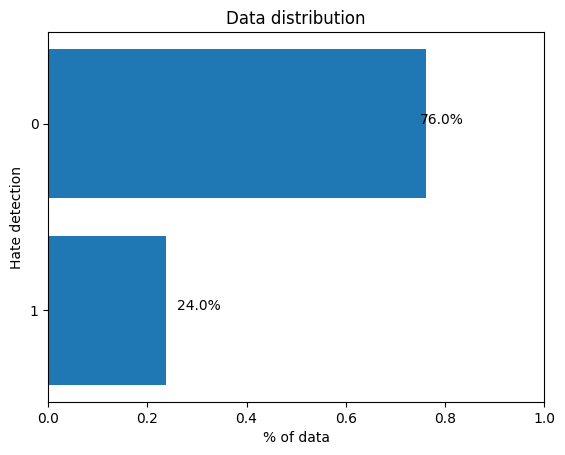

In [5]:
plot_count(counter)

In [6]:
counter = Counter(full_dataset3['hate_speech'])
print('Class 0: {}, Class 1: {}'.format(counter[0],counter[1]))

Class 0: 5271, Class 1: 1430


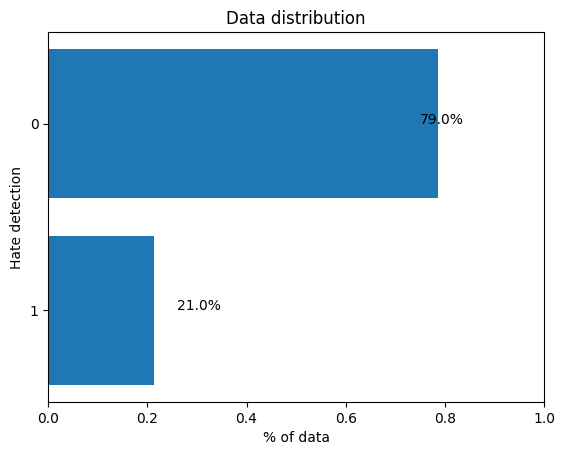

In [7]:
plot_count(counter)

In [8]:
full_dataset2_unbalanced = full_dataset2.copy()
full_dataset3_unbalanced = full_dataset3.copy()

### 2.1 Balancing through translation (oversampling)
The idea here is to translate to a random language and then back to portuguese. This will add random changes to the smaller class.

In [9]:
from textblob import TextBlob
from textblob.translate import NotTranslated
import random
from tqdm import tqdm
import time

from collections import Counter

from pandas import DataFrame
from sklearn.utils import shuffle

In [10]:
language = ["es", "de", "fr", "ar", "te", "hi", "ja", "fa", "sq", "bg", "nl", "gu", "ig", "kk", "mt", "ps", "pt"]

sr = random.SystemRandom()
def data_augmentation_translate(dataframe, class_values=[0,1]):
    count0 = dataframe[dataframe.hate_speech==class_values[0]].count()
    count1 = dataframe[dataframe.hate_speech==class_values[1]].count()
    
    aug_range = abs(count0.text - count1.text)
    
    list_messages = dataframe[dataframe.hate_speech==class_values[1]]['text'].tolist()
    
    len_list = len(list_messages)
    augmented_messages = []

    for j in tqdm(range(0, aug_range)):
    #for j in tqdm(range(0, 1)):
        ind = random.randint(0, len_list)
        message = list_messages[ind-1]
        
        if hasattr(message, "decode"):
            message = message.decode("utf-8")
        
        text = TextBlob(message)
        try:
            text = text.translate(to=sr.choice(language))   ## Converting to random langauge for meaningful variation
            time.sleep(2)
            text = text.translate(to="pt")
        except NotTranslated:
            pass
        augmented_messages.append([str(text), 1])

    df = DataFrame(augmented_messages)
    df.columns = ['text', 'hate_speech']
    
    data = pd.concat([dataframe, df])

    return shuffle(data)

In [11]:
try:
    full_dataset2_balanced_translate = pd.read_csv('datasets\\full_dataset2_balanced_translate.csv')
except FileNotFoundError:
    full_dataset2_balanced_translate = data_augmentation_translate(full_dataset2_unbalanced)
    full_dataset2_balanced_translate.to_csv('datasets\\full_dataset2_balanced_translate.csv', index=False)

In [12]:
try:
    full_dataset3_balanced_translate = pd.read_csv('datasets\\full_dataset3_balanced_translate.csv')
except FileNotFoundError:
    full_dataset3_balanced_translate = data_augmentation_translate(full_dataset3_unbalanced)
    full_dataset3_balanced_translate.to_csv('datasets\\full_dataset3_balanced_translate.csv', index=False)

In [13]:
counter = Counter(full_dataset2_balanced_translate['hate_speech'])
print('Class 0: {}, Class 1: {}'.format(counter[0],counter[1]))

Class 0: 5271, Class 1: 5271


In [14]:
counter = Counter(full_dataset3_balanced_translate['hate_speech'])
print('Class 0: {}, Class 1: {}'.format(counter[0],counter[1]))

Class 0: 5271, Class 1: 5271


### 2.2 Balancing through repetition (oversampling)
Now, we will just repeat some elements of the smaller class. This can generate some problems, such as skew the project.

In [15]:
def data_augmentation_repeating(dataframe, class_values=[0,1]):
    count0 = dataframe[dataframe.hate_speech==class_values[0]].count()
    count1 = dataframe[dataframe.hate_speech==class_values[1]].count()
    
    aug_range = abs(count0.text - count1.text)
    
    list_messages = dataframe[dataframe.hate_speech==class_values[1]]['text'].tolist()
    
    len_list = len(list_messages)
    augmented_messages = []

    for j in range(aug_range):
        ind = random.randint(0, len_list)
        message = list_messages[ind-1]
        
        augmented_messages.append([message, 1])

    df = DataFrame(augmented_messages)
    df.columns = ['text', 'hate_speech']
    
    data = pd.concat([dataframe, df])

    return shuffle(data)

In [16]:
full_dataset2_balanced_repeating = data_augmentation_repeating(full_dataset2_unbalanced)
full_dataset3_balanced_repeating = data_augmentation_repeating(full_dataset3_unbalanced)

In [17]:
counter = Counter(full_dataset2_balanced_repeating['hate_speech'])
print('Class 0: {}, Class 1: {}'.format(counter[0],counter[1]))

Class 0: 5271, Class 1: 5271


In [18]:
counter = Counter(full_dataset3_balanced_repeating['hate_speech'])
print('Class 0: {}, Class 1: {}'.format(counter[0],counter[1]))

Class 0: 5271, Class 1: 5271


### 2.3 Balancing through removing random elements (downsampling)

In [19]:
def downsampling(dataframe, class_values=[0,1]):
    count0 = dataframe[dataframe.hate_speech==class_values[0]].count()
    count1 = dataframe[dataframe.hate_speech==class_values[1]].count()
    
    df1 = dataframe[dataframe.hate_speech==class_values[1]]
    
    diff = abs(count0.text - count1.text)
    list_messages = dataframe[dataframe.hate_speech==class_values[0]]['text'].tolist()

    for j in range(diff):
        ind = random.randint(0, len(list_messages))
        del list_messages[ind-1]

    df = DataFrame({'text':list_messages, 'hate_speech': np.repeat(0, len(list_messages))})
    
    data = pd.concat([df1, df])

    return shuffle(data)

In [20]:
full_dataset2_balanced_downsampling = downsampling(full_dataset2_unbalanced)
full_dataset3_balanced_downsampling = downsampling(full_dataset3_unbalanced)

In [21]:
counter = Counter(full_dataset2_balanced_downsampling['hate_speech'])
print('Class 0: {}, Class 1: {}'.format(counter[0],counter[1]))

Class 0: 1647, Class 1: 1647


In [22]:
counter = Counter(full_dataset3_balanced_downsampling['hate_speech'])
print('Class 0: {}, Class 1: {}'.format(counter[0],counter[1]))

Class 0: 1430, Class 1: 1430


## 3. Preprocessing data

In [23]:
import nltk
#nltk.download('stopwords')
#nltk.download('rslp')

In [24]:
stopwords = set(nltk.corpus.stopwords.words('portuguese')) # get stop words in portuguese

def remove_stopwords(text):
    text_without_stopwords = [word for word in text.split() if word not in stopwords]
    # some elements of the dataset were only stopwords (eg: "quando foi isso")
    # if it's the case, we'll return the same text
    if text_without_stopwords == []:
        return text
    return ' '.join(text_without_stopwords)

from unidecode import unidecode

def cleaning_data(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    text = re.sub(r'[0-9]', '', text)
    text = re.sub(r'rt+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[\"!$%&\'*+,-./<=>?\():;^_`#@{|}~]', '', text)

    text = unidecode(text) #remove accents (e.g.: á, ã, à will be "a")
    return text

def preprocessing(text):
    text = ' '.join(text)
    text = text.lower()
    text_stopwords = remove_stopwords(text)
    text_cleaned = cleaning_data(text_stopwords)
    #text_stemming = stemming(text_stopwords)
    
    return text_cleaned

In [25]:
f = open("datasets\\lista-palavroes-bloqueio.txt", "r", encoding="utf8")
list_bad_words = f.readlines()
list_bad_words = [x.strip() for x in list_bad_words]
f.close()

def tagging_swearwords(text):
    text = [word if (word.upper() not in list_bad_words) else "_SWEARWORD" for word in text.split()]
    text = ' '.join(text)
    return text

def tagging_laughs(text):
    return re.sub(r'k{2,}|a*ha+h[ha]*|e*he+h[he]*|s*rs+r[rs]*', '_LAUGHS ', text)

def preprocessing_full(text):
    text = text.lower()
    text = remove_stopwords(text)
    text = cleaning_data(text)
    text = tagging_swearwords(text)
    text = tagging_laughs(text)
    return text

## 4. Machine learning!

In [26]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score

In [27]:
# unbalanced
text2_unbalanced = full_dataset2_unbalanced['text']
class2_unbalanced = full_dataset2_unbalanced['hate_speech']
text3_unbalanced = full_dataset3_unbalanced['text']
class3_unbalanced = full_dataset3_unbalanced['hate_speech']

# balanced translated
text2_balanced_translate = full_dataset2_balanced_translate['text']
class2_balanced_translate = full_dataset2_balanced_translate['hate_speech']
text3_balanced_translate = full_dataset3_balanced_translate['text']
class3_balanced_translate = full_dataset3_balanced_translate['hate_speech']

# balanced repeating
text2_balanced_repeating = full_dataset2_balanced_repeating['text']
class2_balanced_repeating = full_dataset2_balanced_repeating['hate_speech']
text3_balanced_repeating = full_dataset3_balanced_repeating['text']
class3_balanced_repeating = full_dataset3_balanced_repeating['hate_speech']

# balanced downsampling
text2_balanced_downsampling = full_dataset2_balanced_downsampling['text']
class2_balanced_downsampling = full_dataset2_balanced_downsampling['hate_speech']
text3_balanced_downsampling = full_dataset3_balanced_downsampling['text']
class3_balanced_downsampling = full_dataset3_balanced_downsampling['hate_speech']


### 4.1 Splitting the data: train and test

In [28]:
data_unbalanced_train, text2_unbalanced_test, class2_unbalanced_train, class2_unbalanced_test = train_test_split(text2_unbalanced, class2_unbalanced, test_size=0.3)
text3_unbalanced_train, text3_unbalanced_test, class3_unbalanced_train, class3_unbalanced_test = train_test_split(text3_unbalanced, class3_unbalanced, test_size=0.3)

text2_balanced_translate_train, text2_balanced_translate_test, class2_balanced_translate_train, class2_balanced_translate_test = train_test_split(text2_balanced_translate, class2_balanced_translate, test_size=0.3)
text3_balanced_translate_train, text3_balanced_translate_test, class3_balanced_translate_train, class3_balanced_translate_test = train_test_split(text3_balanced_translate, class3_balanced_translate, test_size=0.3)

text2_balanced_repeating_train, text2_balanced_repeating_test, class2_balanced_repeating_train, class2_balanced_repeating_test = train_test_split(text2_balanced_repeating, class2_balanced_repeating, test_size=0.3)
text3_balanced_repeating_train, text3_balanced_repeating_test, class3_balanced_repeating_train, class3_balanced_repeating_test = train_test_split(text3_balanced_repeating, class3_balanced_repeating, test_size=0.3)

text2_balanced_downsampling_train, text2_balanced_downsampling_test, class2_balanced_downsampling_train, class2_balanced_downsampling_test = train_test_split(text2_balanced_downsampling, class2_balanced_downsampling, test_size=0.3)
text3_balanced_downsampling_train, text3_balanced_downsampling_test, class3_balanced_downsampling_train, class3_balanced_downsampling_test = train_test_split(text3_balanced_downsampling, class3_balanced_downsampling, test_size=0.3)


In [29]:
# data = [x_train, x_test, y_train, y_test]

data2_unbalanced = train_test_split(text2_unbalanced, class2_unbalanced, test_size=0.3)
data3_unbalanced = train_test_split(text3_unbalanced, class3_unbalanced, test_size=0.3)

data2_balanced_translate = train_test_split(text2_balanced_translate, class2_balanced_translate, test_size=0.3)
data3_balanced_translate = train_test_split(text3_balanced_translate, class3_balanced_translate, test_size=0.3)

data2_balanced_repeating = train_test_split(text2_balanced_repeating, class2_balanced_repeating, test_size=0.3)
data3_balanced_repeating = train_test_split(text3_balanced_repeating, class3_balanced_repeating, test_size=0.3)

data2_balanced_downsampling = train_test_split(text2_balanced_downsampling, class2_balanced_downsampling, test_size=0.3)
data3_balanced_downsampling = train_test_split(text3_balanced_downsampling, class3_balanced_downsampling, test_size=0.3)

#### 4.1.1 Random Forest

In [30]:
max_depth_values = range(1, 11)
def random_forest(data):
    train_scores = []
    test_scores = []
    for i in max_depth_values:
        clf = RandomForestClassifier(max_depth=i)
        pipeline = Pipeline([
                            ('bow', CountVectorizer(analyzer=preprocessing_full)),  # strings to token integer counts
                            ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
                            ('classifier', clf) # train on TF-IDF vectors w/ LinearSVC classifier
                            ])
        
        pipeline.fit(data[0], data[2])
        
        train_predict = pipeline.predict(data[0])
        train_accuracy = accuracy_score(data[2], train_predict)
        train_scores.append(train_accuracy)
        
        test_predict = pipeline.predict(data[1])
        test_accuracy = accuracy_score(data[3], test_predict)
        test_scores.append(test_accuracy)  
        
        #print('>%d, train: %.3f, test: %.3f' % (i, train_accuracy, test_accuracy))
        
    return [train_scores, test_scores]


In [31]:
scores_data2_unbalanced = random_forest(data2_unbalanced)
scores_data3_unbalanced = random_forest(data3_unbalanced)

scores_data2_balanced_translate = random_forest(data2_balanced_translate)
scores_data3_balanced_translate = random_forest(data3_balanced_translate)

scores_data2_balanced_repeating = random_forest(data2_balanced_repeating)
scores_data3_balanced_repeating = random_forest(data3_balanced_repeating)

scores_data2_balanced_downsampling = random_forest(data2_balanced_downsampling)
scores_data3_balanced_downsampling = random_forest(data3_balanced_downsampling)

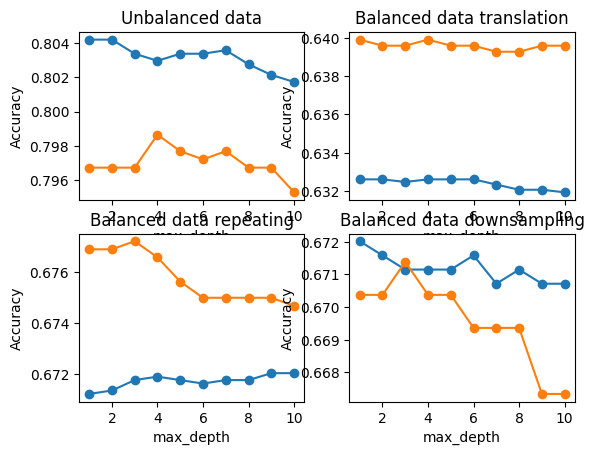

In [58]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(max_depth_values, scores_data2_unbalanced[0], '-o', label='Train')
axs[0, 0].plot(max_depth_values, scores_data2_unbalanced[1], '-o', label='Test')
axs[0, 0].set_title('Unbalanced data')
axs[0, 1].plot(max_depth_values, scores_data2_balanced_translate[0], '-o', label='Train')
axs[0, 1].plot(max_depth_values, scores_data2_balanced_translate[1], '-o', label='Test')
axs[0, 1].set_title('Balanced data translation')
axs[1, 0].plot(max_depth_values, scores_data2_balanced_repeating[0], '-o', label='Train')
axs[1, 0].plot(max_depth_values, scores_data2_balanced_repeating[1], '-o', label='Test')
axs[1, 0].set_title('Balanced data repeating')
axs[1, 1].plot(max_depth_values, scores_data2_balanced_downsampling[0], '-o', label='Train')
axs[1, 1].plot(max_depth_values, scores_data2_balanced_downsampling[1], '-o', label='Test')
axs[1, 1].set_title('Balanced data downsampling')

for ax in axs.flat:
    ax.set(xlabel='max_depth', ylabel='Accuracy')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()

plt.show()


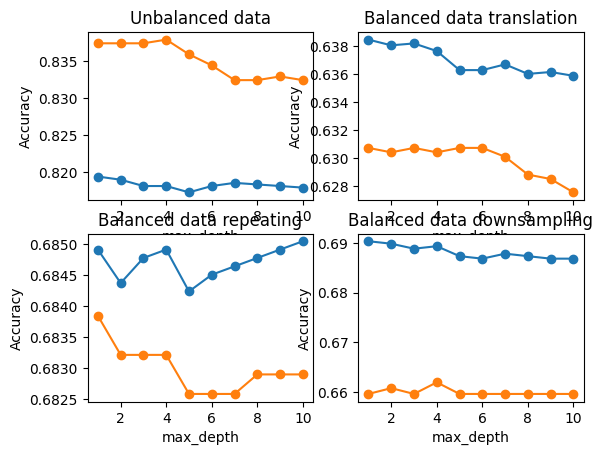

In [57]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(max_depth_values, scores_data3_unbalanced[0], '-o', label='Train')
axs[0, 0].plot(max_depth_values, scores_data3_unbalanced[1], '-o', label='Test')
axs[0, 0].set_title('Unbalanced data')
axs[0, 1].plot(max_depth_values, scores_data3_balanced_translate[0], '-o', label='Train')
axs[0, 1].plot(max_depth_values, scores_data3_balanced_translate[1], '-o', label='Test')
axs[0, 1].set_title('Balanced data translation')
axs[1, 0].plot(max_depth_values, scores_data3_balanced_repeating[0], '-o', label='Train')
axs[1, 0].plot(max_depth_values, scores_data3_balanced_repeating[1], '-o', label='Test')
axs[1, 0].set_title('Balanced data repeating')
axs[1, 1].plot(max_depth_values, scores_data3_balanced_downsampling[0], '-o', label='Train')
axs[1, 1].plot(max_depth_values, scores_data3_balanced_downsampling[1], '-o', label='Test')
axs[1, 1].set_title('Balanced data downsampling')

for ax in axs.flat:
    ax.set(xlabel='max_depth', ylabel='Accuracy')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()

plt.show()

#### 4.1.2 Linear SVC

In [34]:
gamma_values = range(1, 100, 10)
def svc(data):
    train_scores = []
    test_scores = []
    for i in gamma_values:
        clf = SVC(gamma=i)
        pipeline = Pipeline([
                            ('bow', CountVectorizer(analyzer=preprocessing)),  # strings to token integer counts
                            ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
                            ('classifier', clf) # train on TF-IDF vectors w/ LinearSVC classifier
                            ])
        
        pipeline.fit(data[0], data[2])
        
        train_predict = pipeline.predict(data[0])
        train_accuracy = accuracy_score(data[2], train_predict)
        train_scores.append(train_accuracy)
        
        test_predict = pipeline.predict(data[1])
        test_accuracy = accuracy_score(data[3], test_predict)
        test_scores.append(test_accuracy)    
        
    return [train_scores, test_scores]


In [35]:
scores_data2_unbalanced = svc(data2_unbalanced)
scores_data3_unbalanced = svc(data3_unbalanced)

scores_data2_balanced_translate = svc(data2_balanced_translate)
scores_data3_balanced_translate = svc(data3_balanced_translate)

scores_data2_balanced_repeating = svc(data2_balanced_repeating)
scores_data3_balanced_repeating = svc(data3_balanced_repeating)

scores_data2_balanced_downsampling = svc(data2_balanced_downsampling)
scores_data3_balanced_downsampling = svc(data3_balanced_downsampling)

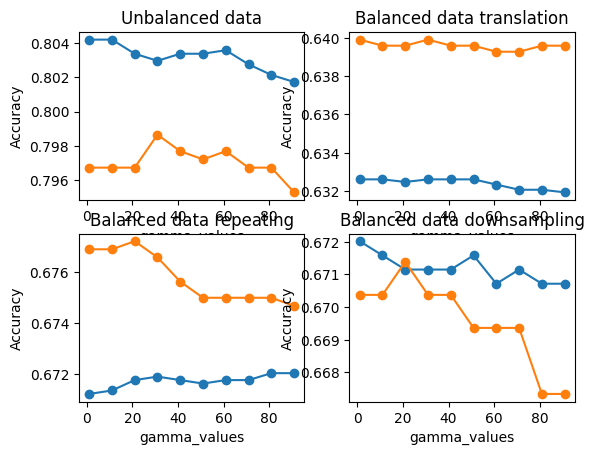

In [56]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(gamma_values, scores_data2_unbalanced[0], '-o', label='Train')
axs[0, 0].plot(gamma_values, scores_data2_unbalanced[1], '-o', label='Test')
axs[0, 0].set_title('Unbalanced data')
axs[0, 1].plot(gamma_values, scores_data2_balanced_translate[0], '-o', label='Train')
axs[0, 1].plot(gamma_values, scores_data2_balanced_translate[1], '-o', label='Test')
axs[0, 1].set_title('Balanced data translation')
axs[1, 0].plot(gamma_values, scores_data2_balanced_repeating[0], '-o', label='Train')
axs[1, 0].plot(gamma_values, scores_data2_balanced_repeating[1], '-o', label='Test')
axs[1, 0].set_title('Balanced data repeating')
axs[1, 1].plot(gamma_values, scores_data2_balanced_downsampling[0], '-o', label='Train')
axs[1, 1].plot(gamma_values, scores_data2_balanced_downsampling[1], '-o', label='Test')
axs[1, 1].set_title('Balanced data downsampling')

for ax in axs.flat:
    ax.set(xlabel='gamma_values', ylabel='Accuracy')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()

plt.show()


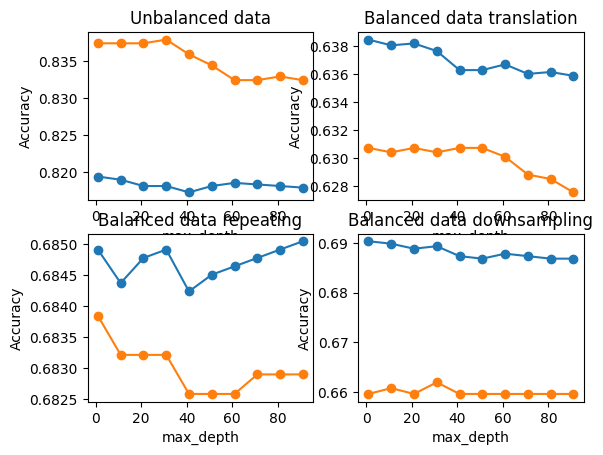

In [55]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(gamma_values, scores_data3_unbalanced[0], '-o', label='Train')
axs[0, 0].plot(gamma_values, scores_data3_unbalanced[1], '-o', label='Test')
axs[0, 0].set_title('Unbalanced data')
axs[0, 1].plot(gamma_values, scores_data3_balanced_translate[0], '-o', label='Train')
axs[0, 1].plot(gamma_values, scores_data3_balanced_translate[1], '-o', label='Test')
axs[0, 1].set_title('Balanced data translation')
axs[1, 0].plot(gamma_values, scores_data3_balanced_repeating[0], '-o', label='Train')
axs[1, 0].plot(gamma_values, scores_data3_balanced_repeating[1], '-o', label='Test')
axs[1, 0].set_title('Balanced data repeating')
axs[1, 1].plot(gamma_values, scores_data3_balanced_downsampling[0], '-o', label='Train')
axs[1, 1].plot(gamma_values, scores_data3_balanced_downsampling[1], '-o', label='Test')
axs[1, 1].set_title('Balanced data downsampling')

for ax in axs.flat:
    ax.set(xlabel='max_depth', ylabel='Accuracy')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()

plt.show()

#### 4.1.3 Multinomial Naive Bayes

In [38]:
alpha_values = range(1, 11)
def multinomial_nb(data):
    train_scores = []
    test_scores = []
    for i in alpha_values:
        clf = MultinomialNB(alpha=i)
        pipeline = Pipeline([
                            ('bow', CountVectorizer(analyzer=preprocessing_full)),  # strings to token integer counts
                            ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
                            ('classifier', clf) # train on TF-IDF vectors w/ LinearSVC classifier
                            ])
        
        pipeline.fit(data[0], data[2])
        
        train_predict = pipeline.predict(data[0])
        train_accuracy = accuracy_score(data[2], train_predict)
        train_scores.append(train_accuracy)
        
        test_predict = pipeline.predict(data[1])
        test_accuracy = accuracy_score(data[3], test_predict)
        test_scores.append(test_accuracy)    
        
    return[train_scores, test_scores]

In [39]:
scores_data2_unbalanced = multinomial_nb(data2_unbalanced)
scores_data3_unbalanced = multinomial_nb(data3_unbalanced)

scores_data2_balanced_translate = multinomial_nb(data2_balanced_translate)
scores_data3_balanced_translate = multinomial_nb(data3_balanced_translate)

scores_data2_balanced_repeating = multinomial_nb(data2_balanced_repeating)
scores_data3_balanced_repeating = multinomial_nb(data3_balanced_repeating)

scores_data2_balanced_downsampling = multinomial_nb(data2_balanced_downsampling)
scores_data3_balanced_downsampling = multinomial_nb(data3_balanced_downsampling)

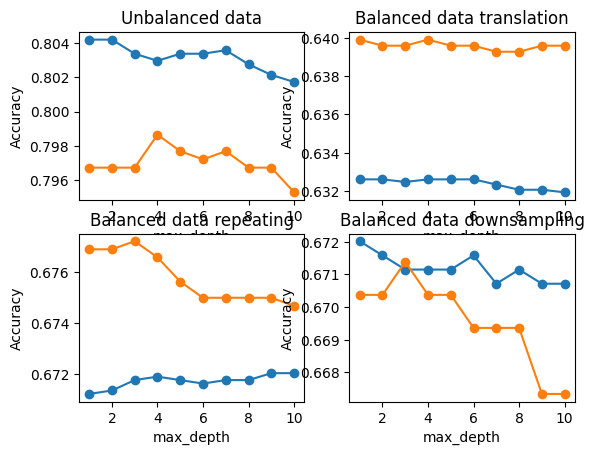

In [54]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(alpha_values, scores_data2_unbalanced[0], '-o', label='Train')
axs[0, 0].plot(alpha_values, scores_data2_unbalanced[1], '-o', label='Test')
axs[0, 0].set_title('Unbalanced data')
axs[0, 1].plot(alpha_values, scores_data2_balanced_translate[0], '-o', label='Train')
axs[0, 1].plot(alpha_values, scores_data2_balanced_translate[1], '-o', label='Test')
axs[0, 1].set_title('Balanced data translation')
axs[1, 0].plot(alpha_values, scores_data2_balanced_repeating[0], '-o', label='Train')
axs[1, 0].plot(alpha_values, scores_data2_balanced_repeating[1], '-o', label='Test')
axs[1, 0].set_title('Balanced data repeating')
axs[1, 1].plot(alpha_values, scores_data2_balanced_downsampling[0], '-o', label='Train')
axs[1, 1].plot(alpha_values, scores_data2_balanced_downsampling[1], '-o', label='Test')
axs[1, 1].set_title('Balanced data downsampling')

for ax in axs.flat:
    ax.set(xlabel='max_depth', ylabel='Accuracy')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()

plt.show()


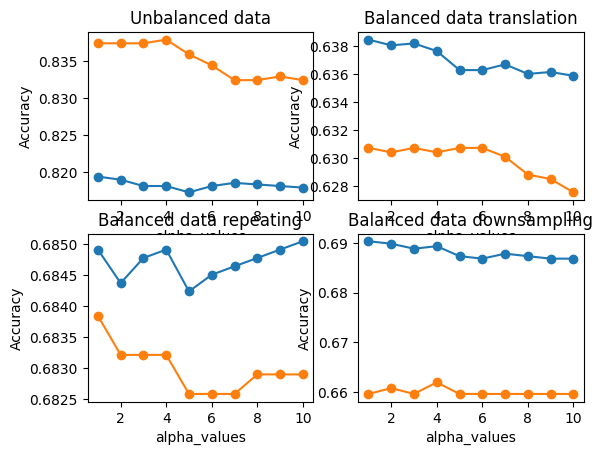

In [59]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(alpha_values, scores_data3_unbalanced[0], '-o', label='Train')
axs[0, 0].plot(alpha_values, scores_data3_unbalanced[1], '-o', label='Test')
axs[0, 0].set_title('Unbalanced data')
axs[0, 1].plot(alpha_values, scores_data3_balanced_translate[0], '-o', label='Train')
axs[0, 1].plot(alpha_values, scores_data3_balanced_translate[1], '-o', label='Test')
axs[0, 1].set_title('Balanced data translation')
axs[1, 0].plot(alpha_values, scores_data3_balanced_repeating[0], '-o', label='Train')
axs[1, 0].plot(alpha_values, scores_data3_balanced_repeating[1], '-o', label='Test')
axs[1, 0].set_title('Balanced data repeating')
axs[1, 1].plot(alpha_values, scores_data3_balanced_downsampling[0], '-o', label='Train')
axs[1, 1].plot(alpha_values, scores_data3_balanced_downsampling[1], '-o', label='Test')
axs[1, 1].set_title('Balanced data downsampling')

for ax in axs.flat:
    ax.set(xlabel='alpha_values', ylabel='Accuracy')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()

plt.show()

### 4.2 Cross-validation

In [42]:
def evaluating(pipeline_model, text, hate_speech):

    pipeline_model.fit(text, hate_speech)

    ## cross validation
    result = cross_val_predict(pipeline_model, text, hate_speech, cv=5)

    a = metrics.classification_report(hate_speech, result, labels=[0,1])
    print(a)
    a = a.split()

    # confusion matrix
    conf_matrix = pd.crosstab(hate_speech, result, margins=True)
    
    return a[7], a[12]

In [43]:
pipeline_LSVC_preproc = Pipeline([
    ('bow', CountVectorizer(analyzer=preprocessing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LinearSVC()),  # train on TF-IDF vectors w/ LinearSVC classifier
])

pipeline_LSVC_preproc_full = Pipeline([
    ('bow', CountVectorizer(analyzer=preprocessing_full)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LinearSVC()),  # train on TF-IDF vectors w/ LinearSVC classifier
])

pipeline_LSVC_preproc_full_ngram = Pipeline([
    ('bow', CountVectorizer(analyzer=preprocessing_full, ngram_range=(1, 2))),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LinearSVC()),  # train on TF-IDF vectors w/ LinearSVC classifier
])



|     Models       |f1-score (0,1) - Hatespeech 2 | f1-score (0,1) - Hatespeech 3 |
| ---   ---        |   ---                        |  ---                          |
| unbalanced       | (0,0)                        | (0,1)                         |
| unb_ngram        | (1,0)                        |                               |
| bal_rep          | (2,0)                        |                               |
| bal_rep_ngram    | (3,0)                        |                               |
| bal_trans        | (4,0)                        |                               |
| bal_trans_ngram  | (5,0)                        |                               |

In [44]:
res_LVC = np.zeros((4, 8))

# hatespeech2, preproc
print('LINEAR SVC')
print('1. Hatespeech2 without laughs and swearword labels')
print('1.1. Unbalanced data')
res_LVC[0][0], res_LVC[0][1] = evaluating(pipeline_LSVC_preproc, text2_unbalanced, class2_unbalanced)
print('1.2. Balanced data - repeating data')
res_LVC[1][0], res_LVC[1][1] = evaluating(pipeline_LSVC_preproc, text2_balanced_repeating, class2_balanced_repeating)
print('1.3. Balanced data - translation')
res_LVC[2][0], res_LVC[2][1] = evaluating(pipeline_LSVC_preproc, text2_balanced_translate, class2_balanced_translate)
print('1.4. Balanced data - downsampling')
res_LVC[3][0], res_LVC[3][1] = evaluating(pipeline_LSVC_preproc, text2_balanced_downsampling, class2_balanced_downsampling)

# hatespeech2, preproc_full
print('2. Hatespeech2 with laughs and swearword labels')
print('2.1. Unbalanced data')
res_LVC[0][2], res_LVC[0][3] = evaluating(pipeline_LSVC_preproc_full, text2_unbalanced, class2_unbalanced)
print('2.2. Balanced data - repeating data')
res_LVC[1][2], res_LVC[1][3] = evaluating(pipeline_LSVC_preproc_full, text2_balanced_repeating, class2_balanced_repeating)
print('2.3. Balanced data - translation')
res_LVC[2][2], res_LVC[2][3] = evaluating(pipeline_LSVC_preproc_full, text2_balanced_translate, class2_balanced_translate)
print('2.4. Balanced data - downsampling')
res_LVC[3][2], res_LVC[3][3] = evaluating(pipeline_LSVC_preproc_full, text2_balanced_downsampling, class2_balanced_downsampling)

# hatespeech3, preproc
print('3. Hatespeech3 without laughs and swearword labels')
print('3.1. Unbalanced data')
res_LVC[0][4], res_LVC[0][5] = evaluating(pipeline_LSVC_preproc, text3_unbalanced, class3_unbalanced)
print('3.2. Balanced data - repeating data')
res_LVC[1][4], res_LVC[1][5] = evaluating(pipeline_LSVC_preproc, text3_balanced_repeating, class3_balanced_repeating)
print('3.3. Balanced data - translation')
res_LVC[2][4], res_LVC[2][5] = evaluating(pipeline_LSVC_preproc, text3_balanced_translate, class3_balanced_translate)
print('3.4. Balanced data - downsampling')
res_LVC[3][4], res_LVC[3][5] = evaluating(pipeline_LSVC_preproc, text3_balanced_downsampling, class3_balanced_downsampling)

# hatespeech3, preproc_full
print('4. Hatespeech3 with laughs and swearword labels')
print('4.1. Unbalanced data')
res_LVC[0][6], res_LVC[0][7] = evaluating(pipeline_LSVC_preproc_full, text3_unbalanced, class3_unbalanced)
print('4.2. Balanced data - repeating data')
res_LVC[1][6], res_LVC[1][7] = evaluating(pipeline_LSVC_preproc_full, text3_balanced_repeating, class3_balanced_repeating)
print('4.3. Balanced data - translation')
res_LVC[2][6], res_LVC[2][7] = evaluating(pipeline_LSVC_preproc_full, text3_balanced_translate, class3_balanced_translate)
print('4.4. Balanced data - downsampling')
res_LVC[3][6], res_LVC[3][7] = evaluating(pipeline_LSVC_preproc_full, text3_balanced_downsampling, class3_balanced_downsampling)

LINEAR SVC
1. Hatespeech2 without laughs and swearword labels
1.1. Unbalanced data
              precision    recall  f1-score   support

           0       0.77      0.98      0.86      5271
           1       0.45      0.05      0.09      1647

    accuracy                           0.76      6918
   macro avg       0.61      0.52      0.48      6918
weighted avg       0.69      0.76      0.68      6918

1.2. Balanced data - repeating data
              precision    recall  f1-score   support

           0       0.64      0.66      0.65      5271
           1       0.65      0.62      0.63      5271

    accuracy                           0.64     10542
   macro avg       0.64      0.64      0.64     10542
weighted avg       0.64      0.64      0.64     10542

1.3. Balanced data - translation
              precision    recall  f1-score   support

           0       0.65      0.70      0.67      5271
           1       0.68      0.62      0.65      5271

    accuracy                  

In [45]:
res_LVC

array([[0.86, 0.09, 0.88, 0.44, 0.88, 0.07, 0.89, 0.46],
       [0.65, 0.63, 0.73, 0.65, 0.65, 0.63, 0.74, 0.68],
       [0.67, 0.65, 0.7 , 0.62, 0.67, 0.65, 0.7 , 0.64],
       [0.64, 0.61, 0.72, 0.65, 0.65, 0.63, 0.73, 0.67]])

In [46]:
pipeline_RF_preproc = Pipeline([
    ('bow', CountVectorizer(analyzer=preprocessing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', RandomForestClassifier()),  # train on TF-IDF vectors w/ LinearSVC classifier
])


pipeline_RF_preproc_full = Pipeline([
    ('bow', CountVectorizer(analyzer=preprocessing_full)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', RandomForestClassifier()),  # train on TF-IDF vectors w/ LinearSVC classifier
])

pipeline_RF_preproc_full_ngram = Pipeline([
    ('bow', CountVectorizer(analyzer=preprocessing_full, ngram_range=(1, 2))),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', RandomForestClassifier()),  # train on TF-IDF vectors w/ LinearSVC classifier
])


In [47]:
res_RF = np.zeros((4, 8))

# hatespeech2, preproc
print('RANDOM FOREST')
print('1. Hatespeech2 without laughs and swearword labels')
print('1.1. Unbalanced data')
res_RF[0][0], res_RF[0][1] = evaluating(pipeline_RF_preproc, text2_unbalanced, class2_unbalanced)
print('1.2. Balanced data - repeating data')
res_RF[1][0], res_RF[1][1] = evaluating(pipeline_RF_preproc, text2_balanced_repeating, class2_balanced_repeating)
print('1.3. Balanced data - translation')
res_RF[2][0], res_RF[2][1] = evaluating(pipeline_RF_preproc, text2_balanced_translate, class2_balanced_translate)
print('1.4. Balanced data - downsampling')
res_RF[3][0], res_RF[3][1] = evaluating(pipeline_RF_preproc, text2_balanced_downsampling, class2_balanced_downsampling)

# hatespeech2, preproc_full
print('2. Hatespeech2 with laughs and swearword labels')
print('2.1. Unbalanced data')
res_RF[0][2], res_RF[0][3] = evaluating(pipeline_RF_preproc_full, text2_unbalanced, class2_unbalanced)
print('2.2. Balanced data - repeating data')
res_RF[1][2], res_RF[1][3] = evaluating(pipeline_RF_preproc_full, text2_balanced_repeating, class2_balanced_repeating)
print('2.3. Balanced data - translation')
res_RF[2][2], res_RF[2][3] = evaluating(pipeline_RF_preproc_full, text2_balanced_translate, class2_balanced_translate)
print('2.4. Balanced data - downsampling')
res_RF[3][2], res_RF[3][3] = evaluating(pipeline_RF_preproc_full, text2_balanced_downsampling, class2_balanced_downsampling)

# hatespeech3, preproc
print('3. Hatespeech3 without laughs and swearword labels')
print('3.1. Unbalanced data')
res_RF[0][4], res_RF[0][5] = evaluating(pipeline_RF_preproc, text3_unbalanced, class3_unbalanced)
print('3.2. Balanced data - repeating data')
res_RF[1][4], res_RF[1][5] = evaluating(pipeline_RF_preproc, text3_balanced_repeating, class3_balanced_repeating)
print('3.3. Balanced data - translation')
res_RF[2][4], res_RF[2][5] = evaluating(pipeline_RF_preproc, text3_balanced_translate, class3_balanced_translate)
print('3.4. Balanced data - downsampling')
res_RF[3][4], res_RF[3][5] = evaluating(pipeline_RF_preproc, text3_balanced_downsampling, class3_balanced_downsampling)

# hatespeech3, preproc_full
print('4. Hatespeech3 with laughs and swearword labels')
print('4.1. Unbalanced data')
res_RF[0][6], res_RF[0][7] = evaluating(pipeline_RF_preproc_full, text3_unbalanced, class3_unbalanced)
print('4.2. Balanced data - repeating data')
res_RF[1][6], res_RF[1][7] = evaluating(pipeline_RF_preproc_full, text3_balanced_repeating, class3_balanced_repeating)
print('4.3. Balanced data - translation')
res_RF[2][6], res_RF[2][7] = evaluating(pipeline_RF_preproc_full, text3_balanced_translate, class3_balanced_translate)
print('4.4. Balanced data - downsampling')
res_RF[3][6], res_RF[3][7] = evaluating(pipeline_RF_preproc_full, text3_balanced_downsampling, class3_balanced_downsampling)

RANDOM FOREST
1. Hatespeech2 without laughs and swearword labels
1.1. Unbalanced data
              precision    recall  f1-score   support

           0       0.77      0.96      0.86      5271
           1       0.44      0.09      0.15      1647

    accuracy                           0.76      6918
   macro avg       0.60      0.53      0.50      6918
weighted avg       0.69      0.76      0.69      6918

1.2. Balanced data - repeating data
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      5271
           1       0.92      0.94      0.93      5271

    accuracy                           0.93     10542
   macro avg       0.93      0.93      0.93     10542
weighted avg       0.93      0.93      0.93     10542

1.3. Balanced data - translation
              precision    recall  f1-score   support

           0       0.75      0.74      0.74      5271
           1       0.74      0.75      0.75      5271

    accuracy               

In [48]:
res_RF

array([[0.86, 0.15, 0.87, 0.43, 0.88, 0.11, 0.89, 0.44],
       [0.93, 0.93, 0.94, 0.94, 0.96, 0.96, 0.95, 0.95],
       [0.74, 0.75, 0.77, 0.73, 0.76, 0.76, 0.78, 0.74],
       [0.66, 0.67, 0.74, 0.66, 0.65, 0.64, 0.74, 0.67]])

In [49]:
pipeline_MNB_preproc = Pipeline([
    ('bow', CountVectorizer(analyzer=preprocessing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ LinearSVC classifier
])

pipeline_MNB_preproc_full = Pipeline([
    ('bow', CountVectorizer(analyzer=preprocessing_full)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ LinearSVC classifier
])

pipeline_MNB_preproc_full_ngram = Pipeline([
    ('bow', CountVectorizer(analyzer=preprocessing_full, ngram_range=(1, 2))),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ LinearSVC classifier
])


In [50]:
res_MNB = np.zeros((4, 8))

# hatespeech2, preproc
print('MULTINOMIAL NAIVE BAYES')
print('1. Hatespeech2 without laughs and swearword labels')
print('1.1. Unbalanced data')
res_MNB[0][0], res_MNB[0][1] = evaluating(pipeline_MNB_preproc, text2_unbalanced, class2_unbalanced)
print('1.2. Balanced data - repeating data')
res_MNB[1][0], res_MNB[1][1] = evaluating(pipeline_MNB_preproc, text2_balanced_repeating, class2_balanced_repeating)
print('1.3. Balanced data - translation')
res_MNB[2][0], res_MNB[2][1] = evaluating(pipeline_MNB_preproc, text2_balanced_translate, class2_balanced_translate)
print('1.4. Balanced data - downsampling')
res_MNB[3][0], res_MNB[3][1] = evaluating(pipeline_MNB_preproc, text2_balanced_downsampling, class2_balanced_downsampling)

# hatespeech2, preproc_full
print('2. Hatespeech2 with laughs and swearword labels')
print('2.1. Unbalanced data')
res_MNB[0][2], res_MNB[0][3] = evaluating(pipeline_MNB_preproc_full, text2_unbalanced, class2_unbalanced)
print('2.2. Balanced data - repeating data')
res_MNB[1][2], res_MNB[1][3] = evaluating(pipeline_MNB_preproc_full, text2_balanced_repeating, class2_balanced_repeating)
print('2.3. Balanced data - translation')
res_MNB[2][2], res_MNB[2][3] = evaluating(pipeline_MNB_preproc_full, text2_balanced_translate, class2_balanced_translate)
print('2.4. Balanced data - downsampling')
res_MNB[3][2], res_MNB[3][3] = evaluating(pipeline_MNB_preproc_full, text2_balanced_downsampling, class2_balanced_downsampling)

# hatespeech3, preproc
print('3. Hatespeech3 without laughs and swearword labels')
print('3.1. Unbalanced data')
res_MNB[0][4], res_MNB[0][5] = evaluating(pipeline_MNB_preproc, text3_unbalanced, class3_unbalanced)
print('3.2. Balanced data - repeating data')
res_MNB[1][4], res_MNB[1][5] = evaluating(pipeline_MNB_preproc, text3_balanced_repeating, class3_balanced_repeating)
print('3.3. Balanced data - translation')
res_MNB[2][4], res_MNB[2][5] = evaluating(pipeline_MNB_preproc, text3_balanced_translate, class3_balanced_translate)
print('3.4. Balanced data - downsampling')
res_MNB[3][4], res_MNB[3][5] = evaluating(pipeline_MNB_preproc, text3_balanced_downsampling, class3_balanced_downsampling)

# hatespeech3, preproc_full
print('4. Hatespeech3 with laughs and swearword labels')
print('4.1. Unbalanced data')
res_MNB[0][6], res_MNB[0][7] = evaluating(pipeline_MNB_preproc_full, text3_unbalanced, class3_unbalanced)
print('4.2. Balanced data - repeating data')
res_MNB[1][6], res_MNB[1][7] = evaluating(pipeline_MNB_preproc_full, text3_balanced_repeating, class3_balanced_repeating)
print('4.3. Balanced data - translation')
res_MNB[2][6], res_MNB[2][7] = evaluating(pipeline_MNB_preproc_full, text3_balanced_translate, class3_balanced_translate)
print('4.4. Balanced data - downsampling')
res_MNB[3][6], res_MNB[3][7] = evaluating(pipeline_MNB_preproc_full, text3_balanced_downsampling, class3_balanced_downsampling)

MULTINOMIAL NAIVE BAYES
1. Hatespeech2 without laughs and swearword labels
1.1. Unbalanced data


c:\users\acer\onedrive\documentos\studies\tcc\hate_speech_detector\venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\acer\onedrive\documentos\studies\tcc\hate_speech_detector\venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\acer\onedrive\documentos\studies\tcc\hate_speech_detector\venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      5271
           1       0.00      0.00      0.00      1647

    accuracy                           0.76      6918
   macro avg       0.38      0.50      0.43      6918
weighted avg       0.58      0.76      0.66      6918

1.2. Balanced data - repeating data
              precision    recall  f1-score   support

           0       0.60      0.67      0.63      5271
           1       0.63      0.56      0.59      5271

    accuracy                           0.61     10542
   macro avg       0.61      0.61      0.61     10542
weighted avg       0.61      0.61      0.61     10542

1.3. Balanced data - translation
              precision    recall  f1-score   support

           0       0.60      0.76      0.67      5271
           1       0.67      0.50      0.58      5271

    accuracy                           0.63     10542
   macro avg       0.64      0.63      0.62     10542
weigh

c:\users\acer\onedrive\documentos\studies\tcc\hate_speech_detector\venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\acer\onedrive\documentos\studies\tcc\hate_speech_detector\venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\acer\onedrive\documentos\studies\tcc\hate_speech_detector\venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

              precision    recall  f1-score   support

           0       0.79      1.00      0.88      5271
           1       0.00      0.00      0.00      1430

    accuracy                           0.79      6701
   macro avg       0.39      0.50      0.44      6701
weighted avg       0.62      0.79      0.69      6701

3.2. Balanced data - repeating data
              precision    recall  f1-score   support

           0       0.62      0.66      0.64      5271
           1       0.64      0.60      0.62      5271

    accuracy                           0.63     10542
   macro avg       0.63      0.63      0.63     10542
weighted avg       0.63      0.63      0.63     10542

3.3. Balanced data - translation
              precision    recall  f1-score   support

           0       0.62      0.73      0.67      5271
           1       0.67      0.56      0.61      5271

    accuracy                           0.64     10542
   macro avg       0.65      0.64      0.64     10542
weigh

In [51]:
res_MNB

array([[0.86, 0.  , 0.88, 0.46, 0.88, 0.  , 0.89, 0.47],
       [0.63, 0.59, 0.73, 0.58, 0.64, 0.62, 0.74, 0.6 ],
       [0.67, 0.58, 0.71, 0.51, 0.67, 0.61, 0.71, 0.5 ],
       [0.63, 0.57, 0.73, 0.58, 0.64, 0.58, 0.74, 0.59]])

In [52]:
res_RF

array([[0.86, 0.15, 0.87, 0.43, 0.88, 0.11, 0.89, 0.44],
       [0.93, 0.93, 0.94, 0.94, 0.96, 0.96, 0.95, 0.95],
       [0.74, 0.75, 0.77, 0.73, 0.76, 0.76, 0.78, 0.74],
       [0.66, 0.67, 0.74, 0.66, 0.65, 0.64, 0.74, 0.67]])

In [53]:
res_LVC

array([[0.86, 0.09, 0.88, 0.44, 0.88, 0.07, 0.89, 0.46],
       [0.65, 0.63, 0.73, 0.65, 0.65, 0.63, 0.74, 0.68],
       [0.67, 0.65, 0.7 , 0.62, 0.67, 0.65, 0.7 , 0.64],
       [0.64, 0.61, 0.72, 0.65, 0.65, 0.63, 0.73, 0.67]])